# Image2Biomass

We will start with loading and exploring the data to see what we're working with

## Step 1 · Load and Explore Data

We gather the training/test metadata and images, run a few sanity checks, inspect biomass ranges, and visualise representative samples.


Training rows (long format): 1,785
Unique training samples: 1,785
Test rows (long format): 5
Unique test samples: 5
Training images found: 357
Test images found: 1
Sample training image shapes:
  ID1011485656.jpg: (1000, 2000, 3)
  ID1012260530.jpg: (1000, 2000, 3)
  ID1025234388.jpg: (1000, 2000, 3)
  ID1028611175.jpg: (1000, 2000, 3)
  ID1035947949.jpg: (1000, 2000, 3)

Missing value ratio (top 10 columns):
sample_id        0.0
image_path       0.0
Sampling_Date    0.0
State            0.0
Species          0.0
Pre_GSHH_NDVI    0.0
Height_Ave_cm    0.0
target_name      0.0
target           0.0
dtype: float64

Biomass target summary:
              count       mean        std   min       max
target_name                                              
Dry_Clover_g  357.0   6.649692  12.117761  0.00   71.7865
Dry_Dead_g    357.0  12.044548  12.402007  0.00   83.8407
Dry_Green_g   357.0  26.624722  25.401232  0.00  157.9836
Dry_Total_g   357.0  45.318097  27.984015  1.04  185.7000
GDM_g     

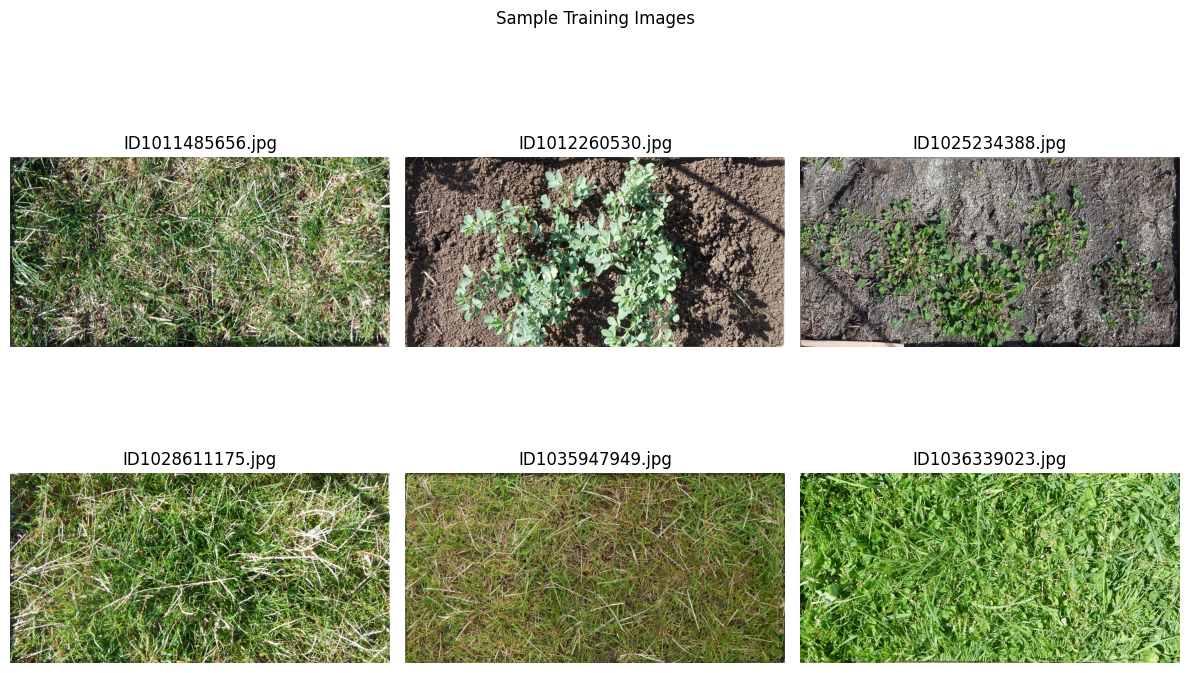

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = Path("/kaggle/input/csiro-biomass")
TRAIN_IMAGES_DIR = DATA_DIR / "train"
TEST_IMAGES_DIR = DATA_DIR / "test"
TRAIN_CSV = DATA_DIR / "train.csv"
TEST_CSV = DATA_DIR / "test.csv"

if not TRAIN_CSV.exists():
    raise FileNotFoundError(
        "Expected competition files under /kaggle/input/csiro-biomass/. "
        "Add the dataset to this notebook to proceed."
    )

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV) if TEST_CSV.exists() else pd.DataFrame()

print(f"Training rows (long format): {len(train_df):,}")
print(f"Unique training samples: {train_df['sample_id'].nunique():,}")
print(f"Test rows (long format): {len(test_df):,}")
print(f"Unique test samples: {test_df['sample_id'].nunique() if not test_df.empty else 0:,}")

train_image_files = sorted(TRAIN_IMAGES_DIR.glob("*.jpg")) if TRAIN_IMAGES_DIR.exists() else []
test_image_files = sorted(TEST_IMAGES_DIR.glob("*.jpg")) if TEST_IMAGES_DIR.exists() else []

print(f"Training images found: {len(train_image_files):,}")
print(f"Test images found: {len(test_image_files):,}")

if train_image_files:
    example_shapes = []
    for path in train_image_files[:5]:
        with Image.open(path) as img:
            example_shapes.append((path.name, np.array(img).shape))
    print("Sample training image shapes:")
    for name, shape in example_shapes:
        print(f"  {name}: {shape}")
else:
    print("No training images found in the expected directory.")

missing_ratio = train_df.isna().mean().sort_values(ascending=False)
print("\nMissing value ratio (top 10 columns):")
print(missing_ratio.head(10))

biomass_summary = (
    train_df.groupby("target_name")["target"]
    .describe()[["count", "mean", "std", "min", "max"]]
)
print("\nBiomass target summary:")
print(biomass_summary)

print("\nSample biomass rows:")
print(train_df[["sample_id", "target_name", "target"]].head())

unique_image_paths = train_df["image_path"].dropna().unique()

# Resolve image paths relative to DATA_DIR
resolved_paths = []
for rel_path in unique_image_paths:
    candidate = DATA_DIR / rel_path
    if candidate.exists():
        resolved_paths.append(candidate)
        continue
    fallback = TRAIN_IMAGES_DIR / Path(rel_path).name
    if fallback.exists():
        resolved_paths.append(fallback)

sample_paths = resolved_paths[:6]
if sample_paths:
    n_images = len(sample_paths)
    n_cols = min(3, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.asarray(axes).reshape(-1)

    for ax, path in zip(axes, sample_paths):
        with Image.open(path) as img:
            ax.imshow(img)
            ax.set_title(path.name)
            ax.axis("off")

    for ax in axes[len(sample_paths):]:
        ax.axis("off")

    plt.suptitle("Sample Training Images")
    plt.tight_layout()
else:
    print("No sample images available to display.")
